In [9]:
import os
import json

import torch
from ts.torch_handler.base_handler import BaseHandler

import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch

from pytorch_forecasting import TimeSeriesDataSet

import logging
logger = logging.getLogger(__name__)

class ForcastHandler(BaseHandler):
    def __init__(self):
        super(ForcastHandler, self).__init__()
        self.initialized = False
        
    def initialize(self, ctx):
        """ Loads the model.pt file and initialized the model object.
        Instantiates Tokenizer for preprocessor to use
        Loads labels to name mapping file for post-processing inference response
        """
        self.manifest = ctx.manifest

        properties = ctx.system_properties
        model_dir = properties.get("model_dir")
        self.device = torch.device("cuda:" + str(properties.get("gpu_id")) if torch.cuda.is_available() else "cpu")

        # Read model serialize/pt file
        serialized_file = self.manifest["model"]["serializedFile"]
        model_pt_path = os.path.join(model_dir, serialized_file)
        if not os.path.isfile(model_pt_path):
            raise RuntimeError("Missing the model.pt or pytorch_model.bin file")
        
        # Load model
        self.model = torch.load(model_pt_path)
        self.model.to(self.device)
        self.model.eval()
        logger.debug('Forecasting model from path {0} loaded successfully'.format(model_dir))
        

        self.initialized = True
        
    def preprocess(self, inputs):
        results = []
        for example in inputs:
            data = example['data']
            
            # Creating forecasting model expects either a dataloader or a timeseriese dataset
            # or a pandas dataframe
            # Eventual input to the model is dictionary of features
            max_prediction_length = 24
            max_encoder_length = 120
            data = pd.DataFrame.from_dict(data)

            # Adding time_idx, time_idx is NOT a feature for the model
            # And is only used in the dataset creation 
            #data["time_idx"] =  data["Date_Time"].dt.year*365*24 + data["Date_Time"].dt.dayofyear * 24 + data["Date_Time"].dt.hour
            #data["time_idx"] -= data["time_idx"].min()
            
            # Adding prediction length entries to all dataset creation
            # It requires at least encoder length + prediction length inputs
            data = pd.concat([data, data.tail(max_prediction_length)], ignore_index=True)
            data['time_idx'] = np.arange(data.shape[0])

            time_varying_known_reals = [
                'p__mbar',
                'Tpot__K',
                'Tdew__degC',
                'rh__percent',
                'VPmax__mbar',
                'VPact__mbar',
                'VPdef__mbar',
                'sh__g_per_kg',
                'H2OC__mmol_per_mol',
                'rho__gm_per_cubic_m',
                'wv__m_per_s',
                'max_w__vm_per_s',
                'wd__deg',
                'time_idx'
            ]
            inference_set = TimeSeriesDataSet(
                data,
                time_idx="time_idx",
                target="T__degC",
                group_ids=["series"],
                time_varying_unknown_reals=["T__degC"],
                time_varying_known_reals=time_varying_known_reals,
                max_encoder_length=max_encoder_length,
                max_prediction_length=max_prediction_length,
                min_encoder_length=max_encoder_length,
                min_prediction_length=max_prediction_length,
                add_relative_time_idx=True,
                add_target_scales=True,
                add_encoder_length=True,
                allow_missing_timesteps=True,
                randomize_length=False,
            )
            #inference_set = TimeSeriesDataSet.from_dataset(inference_set, data, predict=False, stop_randomization=True)
            results.append(inference_set)
        logger.debug('Done creating the inference set(s).')
        
        return results      

    def inference(self, inputs):
        results = []
        for inf_set in inputs:
            results.append(self.model.predict(inf_set))
        return torch.stack(results, dim=0)
    
    def postprocess(self, inputs):
        return inputs.tolist()
        #return inputs
        

In [10]:
from ts.torch_handler.unit_tests.test_utils.mock_context import MockContext

In [11]:
project_id = 'pytorch-tpu-nfs'
dataset_id = 'view_dataset'
table_id = 'weather_time_series_named'
location = 'us-central1'
staging_bucket = 'automl-samples'
experiment_prefix = 'pytorch-forecasting'
from google.cloud import bigquery

sql = f"""
SELECT *
FROM  `{project_id}.{dataset_id}.{table_id}`
LIMIT 122
"""
client = bigquery.Client(location=location, project=project_id)
query_job = client.query(
  sql,
  # Location must match that of the dataset(s) referenced in the query.
  location=location,
)  # API request - starts the query

data = query_job.to_dataframe()

In [12]:
data.describe()

,p__mbar,T__degC,Tpot__K,Tdew__degC,rh__percent,VPmax__mbar,VPact__mbar,VPdef__mbar,sh__g_per_kg,H2OC__mmol_per_mol,rho__gm_per_cubic_m,wv__m_per_s,max_w__vm_per_s,wd__deg
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.00000,122.000000,122.000000
mean,995.282049,-4.581721,268.946721,-6.500246,86.917459,4.437623,3.853033,0.584426,2.413361,3.873770,1289.253443,1.79123,3.088443,167.968115
std,5.483507,2.994214,3.259498,3.300526,9.535174,0.922179,0.897409,0.476958,0.571724,0.916417,19.791656,1.57931,2.253571,94.899591
min,984.740000,-13.640000,259.670000,-15.630000,48.390000,2.120000,1.800000,0.170000,1.120000,1.800000,1259.560000,0.05000,0.380000,0.120000
25%,990.382500,-6.190000,266.962500,-8.632500,87.800000,3.837500,3.177500,0.340000,1.977500,3.182500,1272.312500,0.77000,1.500000,127.600000
50%,997.375000,-4.140000,269.220000,-5.830000,89.900000,4.490000,3.950000,0.445000,2.460000,3.950000,1290.810000,1.34000,2.250000,190.250000
75%,999.862500,-2.090000,271.767500,-4.035000,92.100000,5.235000,4.527500,0.610000,2.822500,4.527500,1301.717500,2.51000,4.130000,231.500000
max,1002.520000,-0.700000,273.480000,-2.310000,96.200000,5.800000,5.150000,2.860000,3.260000,5.230000,1338.680000,7.29000,10.380000,356.400000


In [16]:
# Test Handler
def model_setup(dataframe):
    context = MockContext(model_name="temp_forecasting", model_dir='/home/jupyter/ml-ops-patterns/view_demo/research',)
    sample = dataframe.to_dict()
    return (context, sample)

def test_initialize(model_setup):
    model_context, _ = model_setup
    handler = ForcastHandler()
    handler.initialize(model_context)

    assert(True)
    return handler

def test_handle(model_setup):
    context, data = model_setup
    handler = test_initialize(model_setup)
    test_data = [{'data': data}] * 2
    results = handler.handle(test_data, context)
    print(results)
    #for i in results:
    #    print(f"results_shape:{i.size()}")
    return results

In [17]:
_model_setup = model_setup(data)
test_initialize(_model_setup)

In [18]:
results = test_handle(_model_setup)

[[[-9.165731430053711, -9.079732894897461, -0.5499820709228516, -0.7625815868377686, -0.685187816619873, -0.6929256916046143, -0.9134025573730469, -1.5061759948730469, -3.6042890548706055, -4.412160873413086, -5.267070293426514, -5.505403518676758, -6.40069580078125, -6.909101963043213, -7.399713516235352, -7.729579448699951, -8.05899715423584, -8.226884841918945, -8.22166919708252, -8.508672714233398, -8.688583374023438, -8.759201049804688, -8.913015365600586, -8.981307983398438], [-9.276199340820312, -0.45456838607788086, -0.6778473854064941, -0.6017265319824219, -0.6123695373535156, -0.8546960353851318, -1.539874792098999, -3.7663192749023438, -4.556979656219482, -5.395474433898926, -5.626306056976318, -6.529071807861328, -7.049117565155029, -7.553427696228027, -7.893033981323242, -8.232898712158203, -8.406112670898438, -8.400158882141113, -8.696782112121582, -8.88284683227539, -8.955949783325195, -9.115239143371582, -9.186334609985352, -9.348459243774414], [-0.3508181571960449, -0.

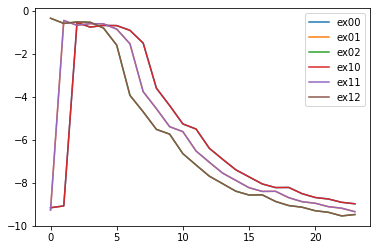

In [20]:
import matplotlib.pyplot as plt

for i,sample in enumerate(results):
    plt.plot(sample[0], label=f'ex{i}0')
    plt.plot(sample[1], label=f'ex{i}1')
    plt.plot(sample[2], label=f'ex{i}2')

plt.legend()
#plt.show()